**Import Necessary Libraries**



In [ ]:
import keras
from keras.models import Sequential
from keras.models import Model,Input
from keras.layers import Dense,concatenate
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.cluster import KMeans
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Read Data and Learn Get Basic Information**

In [ ]:
cd "/content/gdrive/My Drive/"

/content/gdrive/My Drive


In [ ]:
original_data = pd.read_csv("term-deposit-marketing-2020.csv",sep=",")

In [ ]:
# Let us see the general view of the data we read by showing the first two rows

original_data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no


In [ ]:
#Good, we have bunch of continiues and categorical features
#Let us also see the number of samples and the feature datatypes

print("The data contains {} samples and {} features".format(original_data.shape[0],original_data.shape[1]))

print("Features in the dataset have below datatypes:")
original_data.dtypes

The data contains 40000 samples and 14 features
Features in the dataset have below datatypes:


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [ ]:
#Let us check how many unique values are in the categorical features 

for col in original_data.columns:
  print(original_data[col].dtypes)
  if(str(original_data[col].dtypes) == "object"):
    print("Unique values in {} are: {}".format(col, original_data[col].unique()))

int64
object
Unique values in job are: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
object
Unique values in marital are: ['married' 'single' 'divorced']
object
Unique values in education are: ['tertiary' 'secondary' 'unknown' 'primary']
object
Unique values in default are: ['no' 'yes']
int64
object
Unique values in housing are: ['yes' 'no']
object
Unique values in loan are: ['no' 'yes']
object
Unique values in contact are: ['unknown' 'cellular' 'telephone']
int64
object
Unique values in month are: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
int64
int64
object
Unique values in y are: ['no' 'yes']


In [ ]:

#Check number of samples per class

print("Number of samples in class negative class: {}".format(len(original_data[original_data.y == 'no'])))
print("Number of samples in class positive class: {}".format(len(original_data[original_data.y == 'yes'])))

print("We can see that our data have imbalanced class problem, but let us worry about that later")

Number of samples in class negative class: 37104
Number of samples in class positive class: 2896
We can see that our data have imbalanced class problem, but let us worry about that later


**A Basic Classifier**

Before we jump into neural networks, let us try with basic classifier and see how it performs, a dicsion tree for instance.
For that we need to first change the categorical variables.

In [ ]:
modified_data = original_data.copy()

In [ ]:
modified_data['mod_default'] = modified_data['default'].map({'no':0, 'yes':1})
modified_data = modified_data.drop('default',axis = 1)

In [ ]:
modified_data['mod_housing'] = modified_data['housing'].map({'no':0, 'yes':1})
modified_data = modified_data.drop('housing',axis = 1)

In [ ]:
modified_data['mod_loan'] = modified_data['loan'].map({'no':0, 'yes':1})
modified_data = modified_data.drop('loan',axis = 1)

In [ ]:
modified_data['mod_y'] = modified_data['y'].map({'no':0, 'yes':1})
modified_data = modified_data.drop('y',axis = 1)

In [ ]:
#modified_data.columns =  original_data.columns

In [ ]:
modified_data = pd.get_dummies(data=modified_data, columns = ['job', 'marital', 'education','contact','month'], \
                                   prefix = ['job', 'marital', 'education','contact','month'])

In [ ]:
modified_data.tail()

,age,balance,day,duration,campaign,mod_default,mod_housing,mod_loan,mod_y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
39995,53,395,3,107,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
39996,30,3340,3,238,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
39997,54,200,3,170,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
39998,34,1047,3,342,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
39999,38,1442,3,113,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
modified_data.describe()

,age,balance,day,duration,campaign,mod_default,mod_housing,mod_loan,mod_y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175,0.020225,0.600775,0.173250,0.072400,0.112075,0.234575,0.035125,0.027175,0.204150,0.035925,0.035350,0.09775,0.013100,0.171300,0.027600,0.005875,0.118125,0.609650,0.272225,0.156750,0.524825,0.280150,0.038275,0.622850,0.058025,0.319125,0.067950,0.130375,0.000325,0.057400,0.029400,0.159500,0.118350,0.006450,0.338300,0.089950,0.002000
std,9.641776,2903.769716,8.278127,259.366498,3.239051,0.140771,0.489745,0.378468,0.259152,0.315463,0.423738,0.184098,0.162595,0.403084,0.186106,0.184665,0.29698,0.113704,0.376776,0.163826,0.076424,0.322760,0.487835,0.445111,0.363569,0.499390,0.449078,0.191862,0.484679,0.233794,0.466143,0.251663,0.336720,0.018025,0.232608,0.168927,0.366146,0.323026,0.080053,0.473137,0.286114,0.044677
min,19.000000,-8019.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


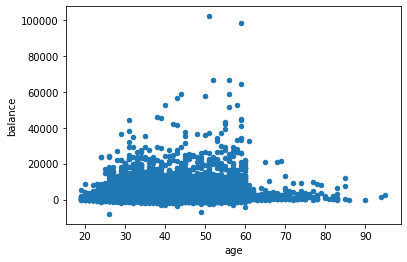

In [ ]:
#Let us sketch how age relates to the balance
modified_data.plot(kind='scatter', x='age', y='balance');

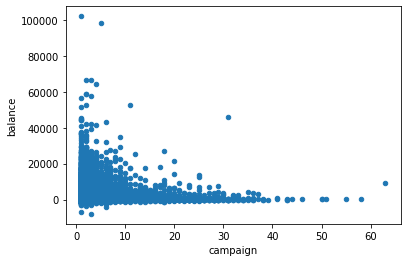

In [ ]:
#How number of compaigns affect the average yearly balance
modified_data.plot(kind='scatter', x='campaign', y='balance');

In [ ]:
# How features in the dataset correlate?

modified_data.corr()

,age,balance,day,duration,campaign,mod_default,mod_housing,mod_loan,mod_y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
age,1.000000,0.081517,-0.011689,-0.036270,0.016204,-0.014857,-0.179606,0.000041,-0.020273,-0.047348,-0.028956,0.027956,0.084920,-0.005302,0.333164,0.001712,-0.057227,-0.155146,-0.058308,0.008052,0.043904,0.161989,0.265630,-0.408589,0.177944,-0.095671,-0.068986,0.073293,-0.068206,0.120689,0.010386,-0.031056,0.088125,-0.005046,-0.006882,-0.020452,0.015661,0.085656,0.004259,-0.129909,0.038068,0.002637
balance,0.081517,1.000000,0.011662,0.014072,-0.008137,-0.070069,-0.049946,-0.080596,0.030232,-0.024774,-0.041461,0.011692,0.003044,0.072172,0.015917,0.015771,-0.033618,0.000575,-0.012655,0.010020,0.010672,-0.025910,0.023683,-0.007168,-0.020949,-0.063920,0.083069,0.011639,0.004086,0.029116,-0.018851,0.017595,0.006746,-0.001729,-0.006996,-0.028811,-0.069231,0.037525,0.017201,-0.061806,0.138829,0.026811
day,-0.011689,0.011662,1.000000,-0.032983,0.165429,0.006287,-0.050622,0.005838,-0.006420,-0.008858,-0.035006,-0.003629,0.005355,0.026526,-0.002787,0.005080,-0.009461,-0.011183,0.031902,-0.005475,-0.009526,-0.004055,0.005243,-0.002806,-0.029240,-0.010139,0.033773,0.002749,0.034320,0.037242,-0.054363,0.041380,0.044390,-0.011766,-0.315910,0.270347,0.163457,-0.211740,-0.013673,-0.046278,0.113071,0.041480
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387,-0.008597,0.022455,-0.003952,0.461169,-0.008152,0.015951,0.000247,-0.007239,-0.010846,0.001675,0.008821,0.003569,-0.007175,-0.008469,0.017896,-0.007971,0.007237,-0.029153,0.026703,-0.007313,0.006765,-0.000303,-0.003043,0.017624,-0.040379,0.001928,0.043029,-0.041387,-0.008212,-0.013193,0.009830,0.017831,-0.021173,-0.010308,0.014137,-0.004876,0.011327
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000,0.012135,-0.054823,0.000582,-0.040350,-0.020156,-0.004635,-0.002619,0.002804,0.021105,-0.013881,0.004581,-0.010404,-0.008503,0.018915,-0.017052,0.017037,-0.019951,0.027962,-0.016179,0.004326,-0.027133,0.022487,0.009791,-0.017733,0.061620,-0.012468,-0.078078,0.176446,-0.010478,-0.032070,-0.067323,0.101728,0.045657,-0.008928,-0.093437,-0.093154,-0.026013
mod_default,-0.014857,-0.070069,0.006287,-0.008597,0.012135,1.000000,-0.019229,0.075006,-0.006559,-0.009384,0.004706,0.025645,0.000017,-0.000951,-0.003878,0.004233,-0.003038,-0.013429,-0.004516,0.007232,-0.006397,0.016748,-0.016458,0.005893,-0.000885,0.011528,-0.012513,0.000959,-0.002889,-0.015149,0.010602,-0.031031,-0.005524,-0.002591,-0.008732,-0.006082,0.042667,0.008387,-0.011576,-0.012644,0.005730,-0.006432
mod_housing,-0.179606,-0.049946,-0.050622,0.022455,-0.054823,-0.019229,1.000000,0.004266,-0.054336,0.039440,0.156122,0.003303,-0.086038,-0.067999,-0.112274,-0.032204,0.062391,-0.034034,-0.032180,-0.046197,-0.077605,-0.004691,0.000680,0.002656,0.011533,0.093628,-0.098019,-0.036128,-0.141946,-0.059696,0.177530,0.077911,-0.342784,-0.013622,-0.071627,-0.068147,-0.082669,-0.118060,-0.055478,0.420169,-0.005101,-0.005784
mod_loan,0.000041,-0.080596,0.005838,-0.003952,0.000582,0.075006,0.004266,1.000000,-0.031029,0.025195,0.005674,0.038244,-0.016788,-0.037817,0.017406,-0.008934,0.031939,-0.047512,0.008396,-0.035591,-0.031734,0.015635,0.032651,-0.047122,-0.012951,0.065472,-0.041987,-0.047598,0.029800,-0.001727,-0.030119,-0.033307,-0.069545,-0.000924,-0.010446,-0.001854,0.172955,-0.027232,-0.022856,-0.050599,0.020236,0.000207
mod_y,-0.020273,0.030232,-0.006420,0.461169,-0.040350,-0.006559,-0.054336,-0.031029,1.000000,0.008083,-0.032859,-0.007191,-0.015248,0.020291,0.024343,0.005029,-0.014645,0.037384,0.000234,0.009463,-0.0

In [ ]:
#Build decision tree classifier
label = modified_data['mod_y']
modified_data = modified_data.drop('mod_y',axis=1)
train_data, test_data, train_label, test_label = train_test_split(modified_data, label, test_size = 0.2, random_state = 50)

In [ ]:
dt_classifier = tree.DecisionTreeClassifier(random_state=1, max_depth=5)
dt_classifier.fit(train_data, train_label)
dt_classifier_train_accu = dt_classifier.score(train_data, train_label)
print("Training accuracy: ",dt_classifier_train_accu)

Training accuracy:  0.939125


In [ ]:
#That is very promising, let us see if this actualy performs that good without even optimaztion
dt_classifier_test_accu = dt_classifier.score(test_data, test_label)
print("Testing accuracy: ",dt_classifier_test_accu)

Testing accuracy:  0.93375


In [ ]:
#This seems great, but it could be the result of imbalanced class problem in the data
#Let us check the actual results

predictions = dt_classifier.predict(test_data)

In [ ]:
np.where(predictions == 0)

(array([   0,    1,    2, ..., 7997, 7998, 7999]),)

In [ ]:
np.where(test_label==0)

(array([   1,    2,    3, ..., 7997, 7998, 7999]),)

*It seems that imbalanced class does not effect the performance of this Model*

**Neural Network Classifier with Keras**

In [ ]:
scaler  = StandardScaler()
scaler.fit(modified_data)

X_train_tf = scaler.transform(train_data)
X_valid_tf = scaler.transform(test_data)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(10, input_dim=41, activation='relu'))
  model.add(Dense(10, input_dim=30, activation='relu'))
  model.add(Dense(10, input_dim=10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
x_train_keras = train_data.values 
x_test_keras = test_data.values
y_train_keras = train_label.values 
y_test_keras = test_label.values

In [ ]:
from sklearn.model_selection import KFold
 
n_split=5
score_array = []
fold = 1
 
for train_index,test_index in KFold(n_split).split(x_train_keras):
  x_train,x_test=x_train_keras[train_index],x_train_keras[test_index]
  y_train,y_test=y_train_keras[train_index],y_train_keras[test_index]
  
  model=create_model()
  model.fit(x_train, y_train,epochs=10,verbose=0)
  prediction = model.predict(x_test_keras)
  score,accuracy = model.evaluate(x_test_keras,y_test_keras)
  score_array.append(accuracy)
  print('Accuracy at fold {}: {} '.format(fold,accuracy))
  fold = fold + 1
print('Average Accuracy: ',np.mean(score_array))

250/250 [==============================] - 0s 829us/step - loss: 0.1919 - accuracy: 0.9265
Accuracy at fold 1: 0.9265000224113464 
250/250 [==============================] - 0s 832us/step - loss: 0.1924 - accuracy: 0.9275
Accuracy at fold 2: 0.9275000095367432 
250/250 [==============================] - 0s 987us/step - loss: 0.1869 - accuracy: 0.9320
Accuracy at fold 3: 0.9319999814033508 
250/250 [==============================] - 0s 1ms/step - loss: 0.1883 - accuracy: 0.9275
Accuracy at fold 4: 0.9275000095367432 
250/250 [==============================] - 0s 880us/step - loss: 0.1971 - accuracy: 0.9293
Accuracy at fold 5: 0.9292500019073486 
Average Accuracy:  0.9285500049591064


**Bonus 1**




For this part, we can use clustering algorithms to group similar customers.




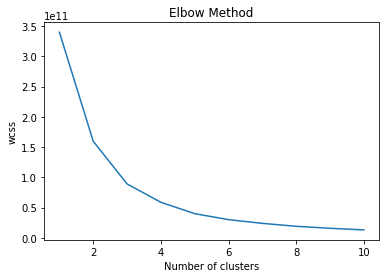

In [ ]:
#Find optimum number of clusters using Elbow method
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(modified_data)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

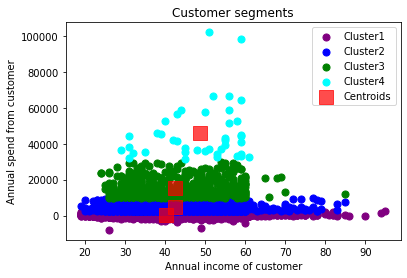

In [ ]:
#We can choose clusters between 4-6 according to elbow
km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(modified_data)
#Visualizing the clusters for k=4
plt.scatter(modified_data.values[y_means==0,0],modified_data.values[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(modified_data.values[y_means==1,0],modified_data.values[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(modified_data.values[y_means==2,0],modified_data.values[y_means==2,1],s=50, c='green',label='Cluster3')
plt.scatter(modified_data.values[y_means==3,0],modified_data.values[y_means==3,1],s=50, c='cyan',label='Cluster4')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Customer segments')
plt.xlabel('Annual income of customer')
plt.ylabel('Annual spend from customer')
plt.legend()
plt.show()

*We could interpret this plot as the following customer segments:*

*   Cluster 1: Customers with medium annual income and low annual spend
*   Cluster 2: Customers with high annual income and medium to high annual spend
*   Cluster 3: Customers with low annual income
*   Cluster 4: Customers with medium annual income but high annual spend

Customers in segment 1 must be targeted and convince them to subsribe the products they can afford.

**Bonus 2**
Loading.........................